$$
G(u, v) = \frac{H^*(u, v)}{|H(u, v)|^2 + \frac{S_{\eta}(u, v)}{S_f(u, v)}} F(u, v)
$$

### 参数解释

- $G(u, v)$: 滤波后图像的频域表示。
- $H(u, v)$: 图像退化函数的频域表示（通常为模糊函数）。
- $H^*(u, v)$: $H(u, v)$ 的共轭复数。
- $F(u, v)$: 原始图像的频域表示。
- $S_{\eta}(u, v)$: 噪声的功率谱密度。
- $S_f(u, v)$: 原始图像的功率谱密度。
- $|H(u, v)|^2$: 退化函数的幅值平方。

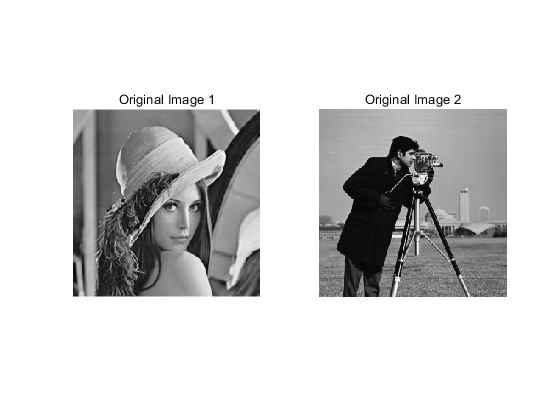

In [69]:
%% 处理数据
% 加载数据
data = load('img_restoration (1).mat');

% 参数设置
gaussian_size = 5;        % 高斯核大小
gaussian_sigma = 5;       % 高斯噪声标准差
motion_len = 20;          % 运动模糊长度
motion_theta = 90;        % 运动模糊角度

% 原始图像
I1 = data.I1;  
I2 = data.I2;
I1 = double(I1);          % 转换为 double 类型
I2 = double(I2);

% 创建运动模糊核
h_motion = fspecial('motion', motion_len, motion_theta);

% 应用运动模糊 
motion_I1 = imfilter(I1, h_motion, 'conv', 'same', 'circular'); % 只有运动模糊
motion_I2 = imfilter(I2, h_motion, 'conv', 'same', 'circular');

% 添加加性高斯噪声
noise_sigma = 5; % 设置噪声强度
noise_I1 = randn(size(motion_I1)) * noise_sigma;
noise_I2 = randn(size(motion_I2)) * noise_sigma;
noisy_motion_I1 = motion_I1 + noise_I1;  % 运动模糊+高斯噪声
noisy_motion_I2 = motion_I2 + noise_I2;

figure;
subplot(1, 2, 1), imshow(I1, []), title('Original Image 1');
subplot(1, 2, 2), imshow(I2, []), title('Original Image 2');


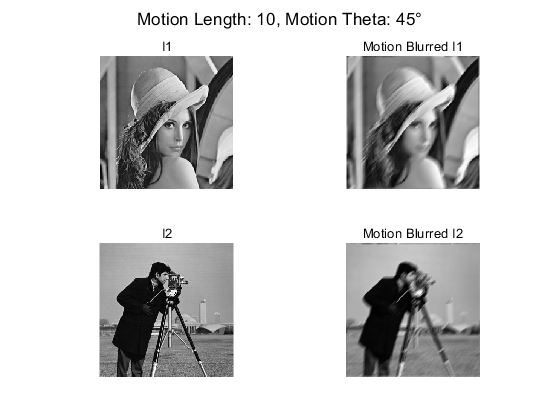

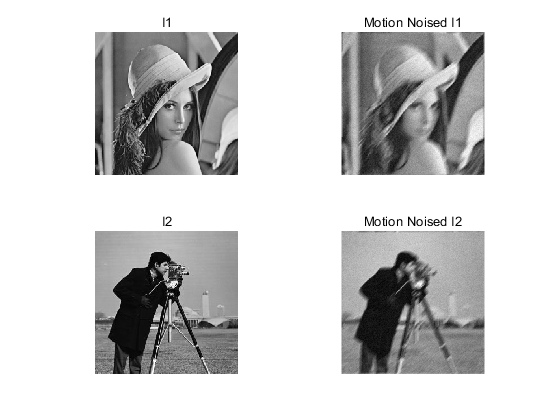

In [2]:

% 显示原图和加高斯噪声后的图像
figure;
subplot(2,2,1), imshow(I1, []), title('I1');
subplot(2,2,2), imshow(motion_I1, []), title('Motion Blurred I1');
subplot(2,2,3), imshow(I2, []), title('I2');
subplot(2,2,4), imshow(motion_I2, []), title('Motion Blurred I2');
sgtitle(sprintf('Motion Length: %d, Motion Theta: %d°', motion_len, motion_theta));


% 显示原图和加运动模糊图像
figure;
subplot(2,2,1), imshow(I1, []), title('I1');
subplot(2,2,2), imshow(noisy_motion_I1, []), title('Motion Noised I1');
subplot(2,2,3), imshow(I2, []), title('I2');
subplot(2,2,4), imshow(noisy_motion_I2, []), title('Motion Noised I2');

%



$$
G(u, v) = \frac{H^*(u, v)}{|H(u, v)|^2 + \frac{S_{\eta}(u, v)}{S_f(u, v)}} F(u, v)
$$

### 参数解释

- $G(u, v)$: 滤波后图像。
- $H(u, v)$: 高斯模糊。
- $F(u, v)$: 原始图像的频域表示。
- $S_{n}(u, v)$: 噪声的功率谱密度。
- $S_f(u, v)$: 原始图像的功率谱密度。


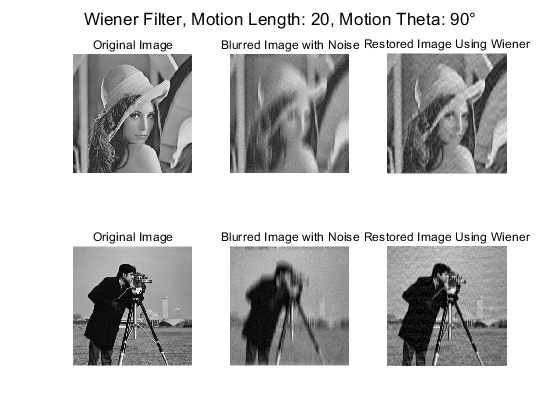

In [70]:
%% 维纳滤波
restore_img_1 = wiener_filter(noisy_motion_I1, I1, noise_I1, h_motion);
restore_img_2 = wiener_filter(noisy_motion_I2, I2, noise_I2, h_motion);
% 显示结果
figure;
subplot(2, 3, 1); imshow(uint8(I1)); title('Original Image');
subplot(2, 3, 2); imshow(uint8(noisy_motion_I1)); title('Blurred Image with Noise');
subplot(2, 3, 3); imshow(uint8(restore_img_1)); title('Restored Image Using Wiener');
subplot(2, 3, 4); imshow(uint8(I2)); title('Original Image');
subplot(2, 3, 5); imshow(uint8(noisy_motion_I2)); title('Blurred Image with Noise');
subplot(2, 3, 6); imshow(uint8(restore_img_2)); title('Restored Image Using Wiener');
sgtitle(sprintf('Wiener Filter, Motion Length: %d, Motion Theta: %d°', motion_len, motion_theta));

### 公式：
$$
\hat{F}(u,v) = \frac{G(u,v)}{H(u,v)}
$$

其中：
- $\hat{F}(u,v)$：恢复后的图像的频谱（频域表示）。
- $G(u,v)$：退化的图像的频谱（带有噪声和模糊）。
- $H(u,v)$：运动模糊核（点扩散函数，PSF）的频域表示（光学传递函数 OTF）。


- 缺点：如果 $H(u,v) $ 在某些频率上接近零，直接逆滤波会导致除零问题，放大噪声，导致严重的恢复不稳定性。

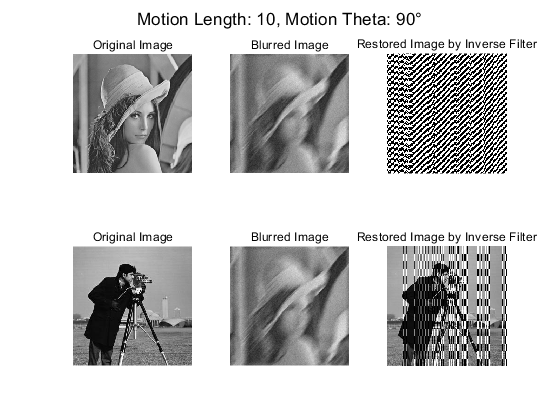

In [66]:
%% 直接逆滤波
% 直接逆滤波存在很多问题，在某些特定角度没办法完成滤波会导致画面崩坏
% inverse_filter(h_motion, motion_I1);
% inverse_filter(h_motion, motion_I2);
motion_len = 10;          % 运动模糊长度
motion_theta = 90;        % 运动模糊角度
h_motion = fspecial('motion', motion_len, motion_theta);

% 应用运动模糊 
motion_I1 = imfilter(I1, h_motion, 'conv', 'same', 'circular'); % 只有运动模糊
motion_I2 = imfilter(I2, h_motion, 'conv', 'same', 'circular');

[M, N] = size(noisy_motion_I1);   % 获取图像的尺寸
H_motion = psf2otf(h_motion, [M, N]);   % 将 PSF (点扩散函数) 转换为 OTF (光学传递函数)
fft_motion_I1 = fft2(noisy_motion_I1);    % 对退化图像进行傅里叶变换
H_motion_conj = conj(H_motion);% 运动模糊核的复共轭
restore_freq = (fft_motion_I1 .* H_motion_conj) ./ abs(H_motion).^2;  % 频域恢复
restore_img_1 = real(ifft2(restore_freq));    % 逆傅里叶变换回到空间域
% 显示退化图像和恢复后的图像



[M, N] = size(motion_I2);   % 获取图像的尺寸
H_motion = psf2otf(h_motion, [M, N]);   % 将 PSF (点扩散函数) 转换为 OTF (光学传递函数)
fft_motion_I2 = fft2(motion_I2);    % 对退化图像进行傅里叶变换
H_motion_conj = conj(H_motion);% 运动模糊核的复共轭
restore_freq = (fft_motion_I2 .* H_motion_conj) ./ abs(H_motion).^2;  % 频域恢复
restore_img_2 = real(ifft2(restore_freq));    % 逆傅里叶变换回到空间域
figure;
subplot(2, 3, 1); imshow(uint8(I1)); title('Original Image');
subplot(2, 3, 2); imshow(uint8(noisy_motion_I1)); title('Blurred Image');
subplot(2, 3, 3); imshow(uint8(restore_img_1)); title('Restored Image by Inverse Filter');
subplot(2, 3, 4); imshow(uint8(I2)); title('Original Image');
subplot(2, 3, 5); imshow(uint8(noisy_motion_I1)); title('Blurred Image');
subplot(2, 3, 6); imshow(uint8(restore_img_2)); title('Restored Image by Inverse Filter');
sgtitle(sprintf('Motion Length: %d, Motion Theta: %d°', motion_len, motion_theta));


### 公式：
$$
\hat{F}(u,v) = \frac{H^*(u,v) \cdot G(u,v)}{|H(u,v)|^2 + \lambda}
$$

其中：
- $\hat{F}(u,v)$：恢复后的图像的频谱（频域表示）。
- $G(u,v)$：退化的图像的频谱（带有噪声和模糊）。
- $H(u,v)$：运动模糊核（点扩散函数，PSF）的频域表示（光学传递函数 OTF）。
- $\lambda$：正则化参数，用于避免除以零或接近零的频率分量。

- 更稳定，尤其是在有噪声的情况下。
- 可以通过调整 $ \lambda $ 来控制恢复的平滑程度和噪声的抑制效果。
- 需要选择合适的正则化参数 $ \lambda $，否则可能会导致恢复结果过于平滑。

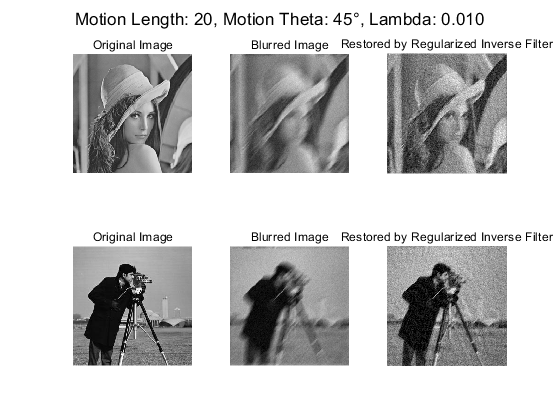

In [68]:
%% 正则化逆滤波
% regularized_inverse_filter(h_motion, motion_I1);
% regularized_inverse_filter(h_motion, motion_I2);
motion_len = 10;          % 运动模糊长度
motion_theta = 0;        % 运动模糊角度
h_motion = fspecial('motion', motion_len, motion_theta);

% 应用运动模糊 
motion_I1 = imfilter(I1, h_motion, 'conv', 'same', 'circular'); % 只有运动模糊
motion_I2 = imfilter(I2, h_motion, 'conv', 'same', 'circular');

[M, N] = size(motion_I1);               % 获取图像的尺寸
H_motion = psf2otf(h_motion, [M, N]);   % 将 PSF (点扩散函数) 转换为 OTF (光学传递函数)
fft_motion_I1 = fft2(motion_I1);        % 对退化图像进行傅里叶变换
H_motion_conj = conj(H_motion);         % 运动模糊核的复共轭
lambda = 0.01;                          % 正则化参数 lambda,  可以根据需要调整这个参数
restore_freq = (fft_motion_I1 .* H_motion_conj) ./ (abs(H_motion).^2 + lambda); % 正则化逆滤波计算
restore_img_1 = real(ifft2(restore_freq));  % 逆傅里叶变换回到空间域

[M, N] = size(motion_I2);               % 获取图像的尺寸
H_motion = psf2otf(h_motion, [M, N]);   % 将 PSF (点扩散函数) 转换为 OTF (光学传递函数)
fft_motion_I2 = fft2(motion_I2);        % 对退化图像进行傅里叶变换
H_motion_conj = conj(H_motion);         % 运动模糊核的复共轭
lambda = 0.01;                          % 正则化参数 lambda,  可以根据需要调整这个参数
restore_freq = (fft_motion_I2 .* H_motion_conj) ./ (abs(H_motion).^2 + lambda); % 正则化逆滤波计算
restore_img_2 = real(ifft2(restore_freq));  % 逆傅里叶变换回到空间域

% 显示退化图像和恢复后的图像
figure;
subplot(2, 3, 1); imshow(uint8(I1)); title('Original Image');
subplot(2, 3, 2); imshow(uint8(motion_I1)); title('Blurred Image');
subplot(2, 3, 3); imshow(uint8(restore_img_1)); title('Restored by Regularized Inverse Filter');
subplot(2, 3, 4); imshow(uint8(I2)); title('Original Image');
subplot(2, 3, 5); imshow(uint8(motion_I2)); title('Blurred Image');
subplot(2, 3, 6); imshow(uint8(restore_img_2)); title('Restored by Regularized Inverse Filter');
sgtitle(sprintf('Motion Length: %d, Motion Theta: %d°, Lambda: %.3f', motion_len, motion_theta, lambda));


### 时域维纳滤波

图像退化模型：

$$
g(x, y) = f(x, y) \ast h(x, y) + \eta(x, y)
$$

滤波器公式（最小化均方误差的维纳滤波器）：

$$
\hat{f}(x, y) = \frac{S_f(x, y)}{S_f(x, y) + S_{\eta}(x, y)} \cdot g(x, y)
$$

### 参数解释

- $\hat{f}(x, y)$: 滤波后恢复的图像。
- $g(x, y)$: 退化后的输入图像。
- $S_f(x, y)$: 原始图像的自相关函数或功率谱密度。
- $S_{\eta}(x, y)$: 噪声的自相关函数或功率谱密度。
- $f(x, y)$: 原始（未退化）图像。
- $h(x, y)$: 退化函数（如模糊核）。
- $\eta(x, y)$: 噪声。
- $\ast$: 表示卷积操作。